In [ ]:
#loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Load CSV
df = pd.read_csv("SyriaTelCustomerChurn.csv")



In [ ]:
#Quick loolk at the data
print(df.head())
print(df.info())
print(df.describe())

  state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...           

In [ ]:
# Drop columns not needed for modeling
columns_to_drop = ['phone number', 'total day charge', 'total eve charge',
                   'total night charge', 'total intl charge']  # Charges are redundant
df_clean = df.drop(columns=columns_to_drop)

# Confirm columns
print(df_clean.columns)


Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total eve minutes', 'total eve calls',
       'total night minutes', 'total night calls', 'total intl minutes',
       'total intl calls', 'customer service calls', 'churn'],
      dtype='object')


In [ ]:
#Convert Yes / No columns to binary
df.select_dtypes(include='object').head()

,state,phone number,international plan,voice mail plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no


In [ ]:
#encoding categorical variables
df['international plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})

In [ ]:
# Check for missing values
print(df_clean.isnull().sum())


state                     0
account length            0
area code                 0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total eve minutes         0
total eve calls           0
total night minutes       0
total night calls         0
total intl minutes        0
total intl calls          0
customer service calls    0
churn                     0
dtype: int64


In [ ]:
#converting churn to binary
df['churn'] = df['churn'].map({True: 1, False: 0})


In [ ]:
##handling state column
df.drop('state', axis=1, inplace=True)

In [ ]:
#dropping the charges
df.drop(['total day charge',
         'total eve charge',
         'total night charge',
         'total intl charge'], axis=1, inplace=True)

In [ ]:
df.shape

(3333, 16)

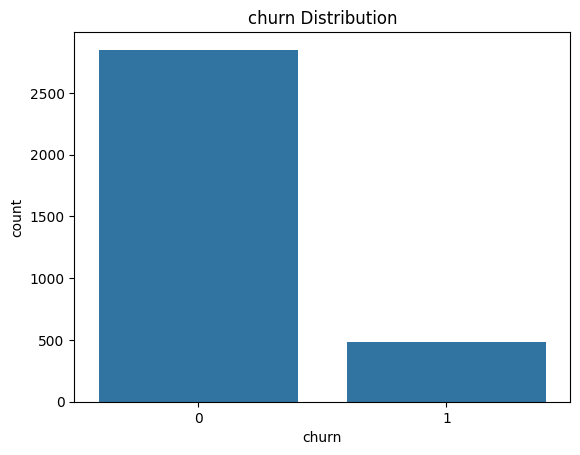

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='churn', data=df)
plt.title("churn Distribution")
plt.show()

In [ ]:
#seperating Features and Target
# Target
y = df['churn']

# Features
X = df.drop('churn', axis=1)

In [ ]:
#Split into Train and Test Sets- i will use 80% training, 20% test, and stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2666, 15)
Test set shape: (667, 15)


In [ ]:
# Drop phone number column
X_train = X_train.drop(columns=['phone number'])
X_test = X_test.drop(columns=['phone number'])

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete. Feature shapes:")
print(X_train_scaled.shape, X_test_scaled.shape)

Scaling complete. Feature shapes:
(2666, 14) (667, 14)


In [ ]:
print(X_train.dtypes)

account length              int64
area code                   int64
international plan          int64
voice mail plan             int64
number vmail messages       int64
total day minutes         float64
total day calls             int64
total eve minutes         float64
total eve calls             int64
total night minutes       float64
total night calls           int64
total intl minutes        float64
total intl calls            int64
customer service calls      int64
dtype: object


In [ ]:
#handling imbalance for training set only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Check balance
print("Churn proportion after SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))



Churn proportion after SMOTE:
churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
#Train baseline logistic regression
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
#Check the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

print("\nChurn proportion in training set:")
print(y_train.value_counts(normalize=True))

print("\nChurn proportion in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (2666, 14) (2666,)
Test set shape: (667, 14) (667,)

Churn proportion in training set:
churn
0    0.855214
1    0.144786
Name: proportion, dtype: float64

Churn proportion in test set:
churn
0    0.854573
1    0.145427
Name: proportion, dtype: float64


In [ ]:
# Predict
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:,1]

In [ ]:
# Evaluation
print("=== Logistic Regression ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_log))

=== Logistic Regression ===
Confusion Matrix:
 [[441 129]
 [ 29  68]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85       570
           1       0.35      0.70      0.46        97

    accuracy                           0.76       667
   macro avg       0.64      0.74      0.66       667
weighted avg       0.85      0.76      0.79       667

ROC-AUC Score: 0.8085548923856032


In [ ]:
#Train random forest (Ensemble & nonparametric)
# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Hyperparameter tuning (max_depth, n_estimators)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    rf_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1
)
grid_rf.fit(X_train_res, y_train_res)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# Best model
best_rf = grid_rf.best_estimator_

# Predict
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# Evaluation
print("=== Random Forest ===")
print("Best Parameters:", grid_rf.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

=== Random Forest ===
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix:
 [[172 398]
 [ 19  78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.30      0.45       570
           1       0.16      0.80      0.27        97

    accuracy                           0.37       667
   macro avg       0.53      0.55      0.36       667
weighted avg       0.79      0.37      0.43       667

ROC-AUC Score: 0.6056791463194067


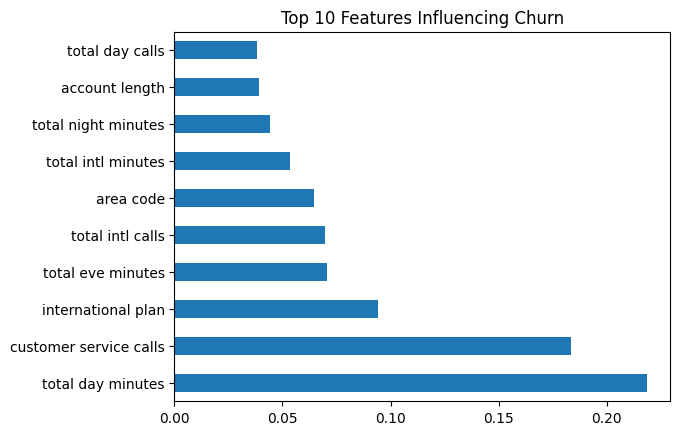

In [ ]:
#Feature importance (for random forest)
feat_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False, inplace=True)

# Plot top 10
feat_imp.head(10).plot(kind='barh', title='Top 10 Features Influencing Churn')
plt.show()